# QIIME2 Analysis

### Import Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import zipfile
import glob
from skbio.stats.ordination import pcoa
from skbio import DistanceMatrix
import matplotlib.dates as mdates
from palettable.tableau import Tableau_20 as pr
%matplotlib inline

# 18S

### Load and convert data into tsv file

In [2]:
filename_asv18s = 'outside_influence/data/filtered_seq_data/outside_18S_asv_filtered.csv'
filename_meta18s = 'outside_influence/data/filtered_seq_data/outside_18S_meta_filtered.csv'
filename_seq18s = 'outside_influence/data/filtered_seq_data/outside_18S_seq_filtered.csv'
filename_taxa18s = 'outside_influence/data/filtered_seq_data/outside_18S_taxa_filtered.csv'

df_asv18 = pd.read_csv(filename_asv18s, na_values=-999, index_col=0)
df_meta18 = pd.read_csv(filename_meta18s, na_values=-999, index_col=0)
df_seq18 = pd.read_csv(filename_seq18s, na_values=-999, index_col=0)
df_taxa18 = pd.read_csv(filename_taxa18s, na_values=-999, index_col=0)

In [7]:
df_taxa18.index.name = '#OTUID'
df_asv18.index.name = '#OTUID'
df_meta18.index.name = '#SampleID'
df_metasub18 = df_meta18[['date', 'salinity', 'temp', 'nitrate', 'chlorophyll' ]]

In [6]:
df_metasub18.to_csv('QIIME_data/outside_18S_meta_filtered.tsv', sep='\t', index=True) #transform meta .csv to .tsv
df_asv18.to_csv('QIIME_data/outside_18S_asv_filtered.tsv', sep='\t', index=True) #transform asv .csv to .tsv
df_taxa18.to_csv('QIIME_data/outside_18S_taxa_filtered.tsv', sep='\t', index=True) #transform asv .csv to .tsv

### Create a BIOM file and import into QIIME

In [7]:
!biom convert \-i QIIME_data/outside_18S_asv_filtered.tsv \-o QIIME_data/table.biom \--table-type="OTU table" \--to-json
!biom add-metadata \-i QIIME_data/table.biom \-o QIIME_data/table_meta.biom \--sample-metadata-fp QIIME_data/outside_18S_meta_filtered.tsv
!biom add-metadata \-i QIIME_data/table_meta.biom \-o QIIME_data/table_complete.biom \--observation-metadata-fp QIIME_data/outside_18S_taxa_filtered.tsv

In [8]:
!qiime tools import \--input-path QIIME_data/table_complete.biom \--type 'FeatureTable[Frequency]' \--input-format BIOMV210Format \--output-path QIIME_data/table.qza

#Visualize the table to figure out sampling depth. 26000 (keep 99.06%)
!qiime feature-table summarize --i-table QIIME_data/table.qza --m-sample-metadata-file QIIME_data/outside_18S_meta_filtered.tsv --o-visualization QIIME_vis/table.qzv

/opt/anaconda3/envs/QIIME2/lib/python3.10/site-packages/q2_demux/_summarize/_visualizer.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Imported QIIME_data/table_complete.biom as BIOMV210Format to QIIME_data/table.qza
/opt/anaconda3/envs/QIIME2/lib/python3.10/site-packages/q2_demux/_summarize/_visualizer.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: QIIME_vis/table.qzv


### Sampling Depth

In [9]:
!qiime feature-table rarefy \--i-table QIIME_data/table.qza \--p-sampling-depth 15000 \--o-rarefied-table QIIME_data/rarefied-table.qza

/opt/anaconda3/envs/QIIME2/lib/python3.10/site-packages/q2_demux/_summarize/_visualizer.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: QIIME_data/rarefied-table.qza


In [10]:
qza_path = "QIIME_data/rarefied-table.qza"
unzip_dir = "QIIME_data/unzip_rarefied"

with zipfile.ZipFile(qza_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)
folder_path = glob.glob('QIIME_data/unzip_rarefied/*/data/feature-table.biom')[0]

In [11]:
!biom convert \-i "{folder_path}" \-o QIIME_data/rarefied_table.txt --to-tsv

### Subset by Taxa

In [12]:
df_rare18 = pd.read_csv('QIIME_data/rarefied_table.txt', sep='\t', skiprows=1, index_col=0)
df_rare18 = df_rare18.T
df_subrare18 = df_rare18.join(df_meta18[['date','salinity', 'temp', 'SAMPLING_station', 'nitrate', 'chlorophyll']], how='outer')

df_c1_sub18= df_subrare18[df_subrare18['SAMPLING_station'].isin(['C1', 'c1'])]#Pick the station to subset
#df_metasub18 = df_meta18[df_meta18['SAMPLING_station'].isin(['MOORING1', 'mooring1', 'Mooring 1', 'M1', 'moring1', 'Mooring1'])] #Subsample M1
#df_metasub18 = df_meta18[df_meta18['SAMPLING_station'].isin(['MOORING2', 'mooring2', 'Mooring 2'])]#Subsample M2

df_c1_meta = df_c1_sub18[['date','salinity', 'temp', 'nitrate', 'chlorophyll']]
df_combined18 = df_taxa18.join(df_c1_sub18.T, how='inner')
df_filter18 = df_combined18[df_combined18['Class'] == 'Dinophyceae'] #pick the taxa to subset
df_clean_shan18 = df_filter18.drop(['Kingdom', 'Phylum', 'Order', 'Class', 'Family','Genus', 'Species'] , axis = 1)
df_clean_taxa18 = df_filter18[['Kingdom', 'Phylum', 'Order', 'Class', 'Family','Genus', 'Species']]
df_clean_meta18 = df_c1_meta.join(df_clean_shan18.T, how='inner')
df_clean_meta18 = df_clean_meta18[['date','salinity', 'temp', 'nitrate', 'chlorophyll']]

df_clean_shan18.index.name = '#OTUID'
df_clean_taxa18.index.name = '#OTUID'
df_clean_meta18.index.name = '#SampleID'

df_clean_shan18.to_csv('QIIME_data/filtered_shan18_Dino.tsv', sep='\t', index=True) #transform meta .csv to .tsv
df_clean_taxa18.to_csv('QIIME_data/filtered18_taxa18_Dino.tsv', sep='\t', index=True) #transform meta .csv to .tsv
df_clean_meta18.to_csv('QIIME_data/filtered_meta18_Dino.tsv', sep='\t', index=True) #transform meta .csv to .tsv

### Create a BIOM file with the subset data

In [13]:
!biom convert \-i QIIME_data/filtered_shan18_Dino.tsv \-o QIIME_data/filtered18_Dino.biom \--table-type="OTU table" \--to-json
!biom add-metadata \-i QIIME_data/filtered18_Dino.biom \-o QIIME_data/filtered_meta18_Dino.biom \--sample-metadata-fp QIIME_data/filtered_meta18_Dino.tsv
!biom add-metadata \-i QIIME_data/filtered_meta18_Dino.biom \-o QIIME_data/filtered_complete18_Dino.biom \--observation-metadata-fp QIIME_data/filtered18_taxa18_Dino.tsv

!qiime tools import \--input-path QIIME_data/filtered_complete18_Dino.biom \--type 'FeatureTable[Frequency]' \--input-format BIOMV210Format \--output-path QIIME_data/rarefied_filtered18_Dino.qza

/opt/anaconda3/envs/QIIME2/lib/python3.10/site-packages/q2_demux/_summarize/_visualizer.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Imported QIIME_data/filtered_complete18_Dino.biom as BIOMV210Format to QIIME_data/rarefied_filtered18_Dino.qza


### Shannon Diversity

In [14]:
#Alpha Shannon diversity
!qiime diversity alpha \--i-table QIIME_data/rarefied_filtered18_Dino.qza \--p-metric shannon \--o-alpha-diversity QIIME_data/shannon_filtered18_Dino.qza
#visualize
!qiime metadata tabulate \--m-input-file QIIME_data/shannon_filtered18_Dino.qza \--o-visualization QIIME_vis/shannon_filtered18_Dino.qzv

/opt/anaconda3/envs/QIIME2/lib/python3.10/site-packages/q2_demux/_summarize/_visualizer.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved SampleData[AlphaDiversity] to: QIIME_data/shannon_filtered18_Dino.qza
/opt/anaconda3/envs/QIIME2/lib/python3.10/site-packages/q2_demux/_summarize/_visualizer.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/anaconda3/envs/QIIME2/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_nu

### Simpson Diverity

In [6]:
#Simpson
!qiime diversity alpha \--i-table QIIME_data/rarefied_filtered18.qza \--p-metric simpson \--o-alpha-diversity QIIME_data/simpson_vector.qza
!qiime diversity alpha-group-significance \--i-alpha-diversity QIIME_data/simpson_vector.qza \--m-metadata-file QIIME_data/filtered_meta18.tsv \--o-visualization QIIME_vis/simpson18_Bacillariophyta.qzv

/opt/anaconda3/envs/QIIME2/lib/python3.10/site-packages/q2_demux/_summarize/_visualizer.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved SampleData[AlphaDiversity] to: QIIME_data/simpson_vector.qza
/opt/anaconda3/envs/QIIME2/lib/python3.10/site-packages/q2_demux/_summarize/_visualizer.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: QIIME_vis/simpson18_Bacillariophyta.qzv


### Bray Curtis & PCOA

In [17]:
#Bray Curtiz and PCOA. CHANGE NAMES
!qiime diversity beta \--i-table QIIME_data/rarefied_filtered18_Dino.qza \--p-metric braycurtis \--o-distance-matrix QIIME_data/braycurtis_distance_Dino.qza
!qiime diversity pcoa \--i-distance-matrix QIIME_data/braycurtis_distance_Dino.qza \--o-pcoa QIIME_data/braycurtis_pcoa_Dino.qza
!qiime emperor plot \--i-pcoa QIIME_data/braycurtis_pcoa__Dino.qza \--m-metadata-file QIIME_data/filtered_meta18_Dino.tsv \--o-visualization QIIME_vis/braycurtis_emperor_Dino.qzv

/opt/anaconda3/envs/QIIME2/lib/python3.10/site-packages/q2_demux/_summarize/_visualizer.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved DistanceMatrix to: QIIME_data/braycurtis_distance_Dino.qza
/opt/anaconda3/envs/QIIME2/lib/python3.10/site-packages/q2_demux/_summarize/_visualizer.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved PCoAResults to: QIIME_data/braycurtis_pcoa__Dino.qza
/opt/anaconda3/envs/QIIME2/lib/python3.10/site-packages/q2_demux/_summarize/_visualizer.py:11: UserWarning: pkg_resources is deprecated as an API. See https

============STOP==================


For Shannon download, place in QIIME_vis, and rename to shannon_filter18_meta.tsv

In [7]:
df_shan = pd.read_csv("QIIME_vis/shannon_filter18_meta.tsv", sep="\t", na_values=-999)
df_shan = df_shan.iloc[1:].reset_index(drop=True)
df_shan = df_shan.set_index(df_shan.columns[0])

df= pd.concat([df_meta18['date'], df_shan], axis=1,join='inner')
df['Date'] = pd.to_datetime(df['date'], errors='coerce')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')
#df= df[(df['Date'].dt.year == 2020)] #filter out a year
df['year'] = df['Date'].dt.year
df = df.drop(['date','Date'], axis =1)
df = df.reset_index()
df = df.drop('index', axis=1)
df['shannon_entropy'] = pd.to_numeric(df['shannon_entropy'], errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')

/opt/anaconda3/envs/QIIME2/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/QIIME2/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/QIIME2/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


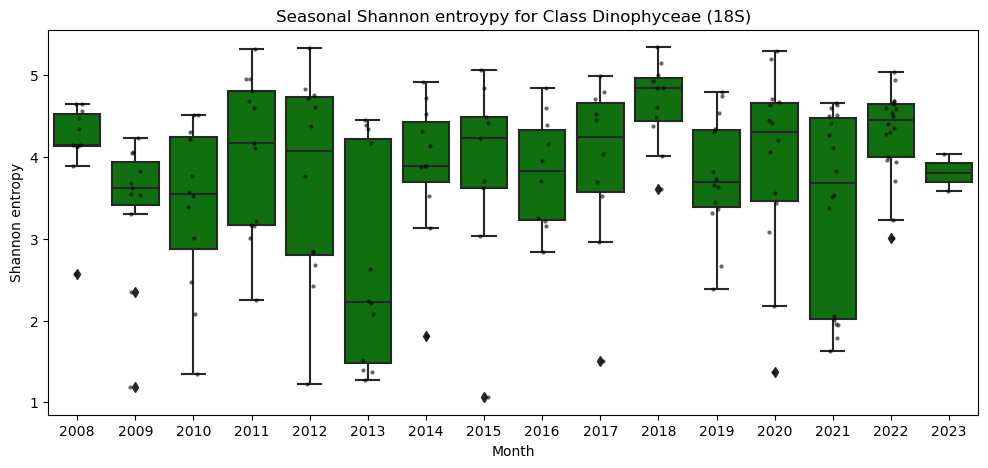

In [9]:
plt.figure(figsize=(12, 5))
sns.boxplot(x = df['year'], y = df['shannon_entropy'], color='green')
sns.stripplot(x = df['year'], y = df['shannon_entropy'], color='black', size=3, jitter=True, alpha=0.6)
plt.ylabel('Shannon entropy')
plt.xlabel('Month')
plt.title('Seasonal Shannon entroypy for Class Dinophyceae (18S)')

#plt.savefig("QIIME_images/Shannon_18S_Dinophyceae.png", dpi=300, bbox_inches='tight')
plt.show()

### PCoA

In [18]:
!qiime tools export \--input-path QIIME_data/braycurtis_distance_Dino.qza \--output-path QIIME_data/braycurtis_distance_Dino/

/opt/anaconda3/envs/QIIME2/lib/python3.10/site-packages/q2_demux/_summarize/_visualizer.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Exported QIIME_data/braycurtis_distance_Dino.qza as DistanceMatrixDirectoryFormat to directory QIIME_data/braycurtis_distance_Dino/


In [20]:
!qiime tools export \--input-path QIIME_data/braycurtis_pcoa_Dino.qza \--output-path QIIME_data/braycurtis_pcoa_Dino/

/opt/anaconda3/envs/QIIME2/lib/python3.10/site-packages/q2_demux/_summarize/_visualizer.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Exported QIIME_data/braycurtis_pcoa_Dino.qza as OrdinationDirectoryFormat to directory QIIME_data/braycurtis_pcoa_Dino/


In [3]:
df_dia = pd.read_csv('QIIME_data/braycurtis_distance_Dino/distance-matrix.tsv', sep='\t', skiprows=0, index_col=0)
df_din = pd.read_csv('QIIME_data/braycurtis_distance_Bacillariophyta/distance-matrix.tsv', sep='\t', skiprows=0, index_col=0)

dm_dia = DistanceMatrix(df_dia.values, ids=df_dia.index)
pcoa_results_dia = pcoa(dm_dia)
coords_df_dia = pcoa_results_dia.samples 

dm_din = DistanceMatrix(df_din.values, ids=df_din.index)
pcoa_results_din = pcoa(dm_din)
coords_df_din = pcoa_results_din.samples 

/opt/anaconda3/envs/QIIME2/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.20235107047809747 and the largest is 8.301455240575736.
  warn(
/opt/anaconda3/envs/QIIME2/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eig

In [4]:
features_df = df_asv18.T.loc[coords_df_dia.index]
loadings = pd.DataFrame({
    'PC1': features_df.corrwith(coords_df_dia['PC1']),
    'PC2': features_df.corrwith(coords_df_dia['PC2'])
})
loadings

/opt/anaconda3/envs/QIIME2/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/QIIME2/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,PC1,PC2
ASV_1,-0.016093,-0.140333
ASV_2,0.240890,-0.286623
ASV_3,-0.682819,-0.056518
ASV_4,0.078271,0.072905
ASV_5,0.139762,0.543699
...,...,...
ASV_63221,-0.043013,0.104327
ASV_63225,-0.034393,0.058072
ASV_63320,NaN,NaN
ASV_63344,-0.050337,-0.033620


#### PCoA Biplot
Make sure to change coords_df_dia to coords_df_din if you want to do dinoflagellates.

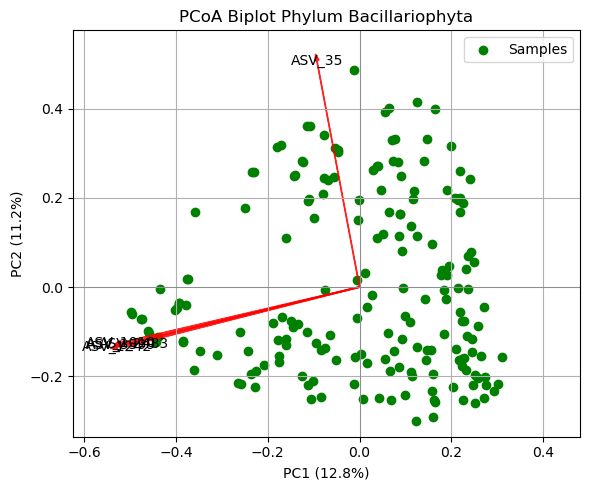

In [5]:
plt.style.use('default')
plt.figure(figsize=(6, 5))

plt.scatter(coords_df_dia['PC1'], coords_df_dia['PC2'], color='green', label='Samples', alpha=1)

top_n = 5
top_features = loadings.apply(lambda col: col.abs()).sum(axis=1).nlargest(top_n).index

arrow_scale = 0.8  
label_offset = 1.0 

for feature in top_features:
    x, y = loadings.loc[feature, 'PC1'], loadings.loc[feature, 'PC2']
    x_arrow, y_arrow = x * arrow_scale, y * arrow_scale
    plt.arrow(0, 0, x_arrow, y_arrow, color='red', alpha=0.8, head_width=0.01)
    plt.text(x_arrow * label_offset, y_arrow * label_offset, feature,
             fontsize=10, color='black', ha='center', va='center')

plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)

plt.xlabel(f"PC1 ({pcoa_results_dia.proportion_explained['PC1'] * 100:.1f}%)")
plt.ylabel(f"PC2 ({pcoa_results_dia.proportion_explained['PC2'] * 100:.1f}%)")
plt.title('PCoA Biplot Phylum Bacillariophyta')
plt.grid(True)
plt.legend()

buffer = 1.2 * arrow_scale
pc1_vals = coords_df_dia['PC1']
pc2_vals = coords_df_dia['PC2']
plt.xlim(min(pc1_vals.min(), -.65) * buffer, max(pc1_vals.max(), .5) * buffer)
plt.ylim(min(pc2_vals.min(), -.35) * buffer, max(pc2_vals.max(), .6) * buffer)

plt.tight_layout()

#plt.savefig("Seasonal_images/PcoaBiplot_18S_P_Dia.png", dpi=300, bbox_inches='tight')
plt.show()

#### Identify the top ASV's in biplot

In [119]:
top_features

Index(['ASV_1242', 'ASV_3399', 'ASV_1010', 'ASV_2483', 'ASV_35'], dtype='object')

In [6]:
top_taxa = df_taxa18.loc[top_features]
df_asv_per = df_asv18.div(df_asv18.sum(axis=0), axis=1) *100
df_top18=pd.concat([df_asv_per, top_taxa], axis=1, join='inner')
levels= ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
df_top18=df_top18.groupby(levels).sum()
df_top18=df_top18.sort_index()
df_top18=df_top18.T
df_top18=df_top18.sort_index()

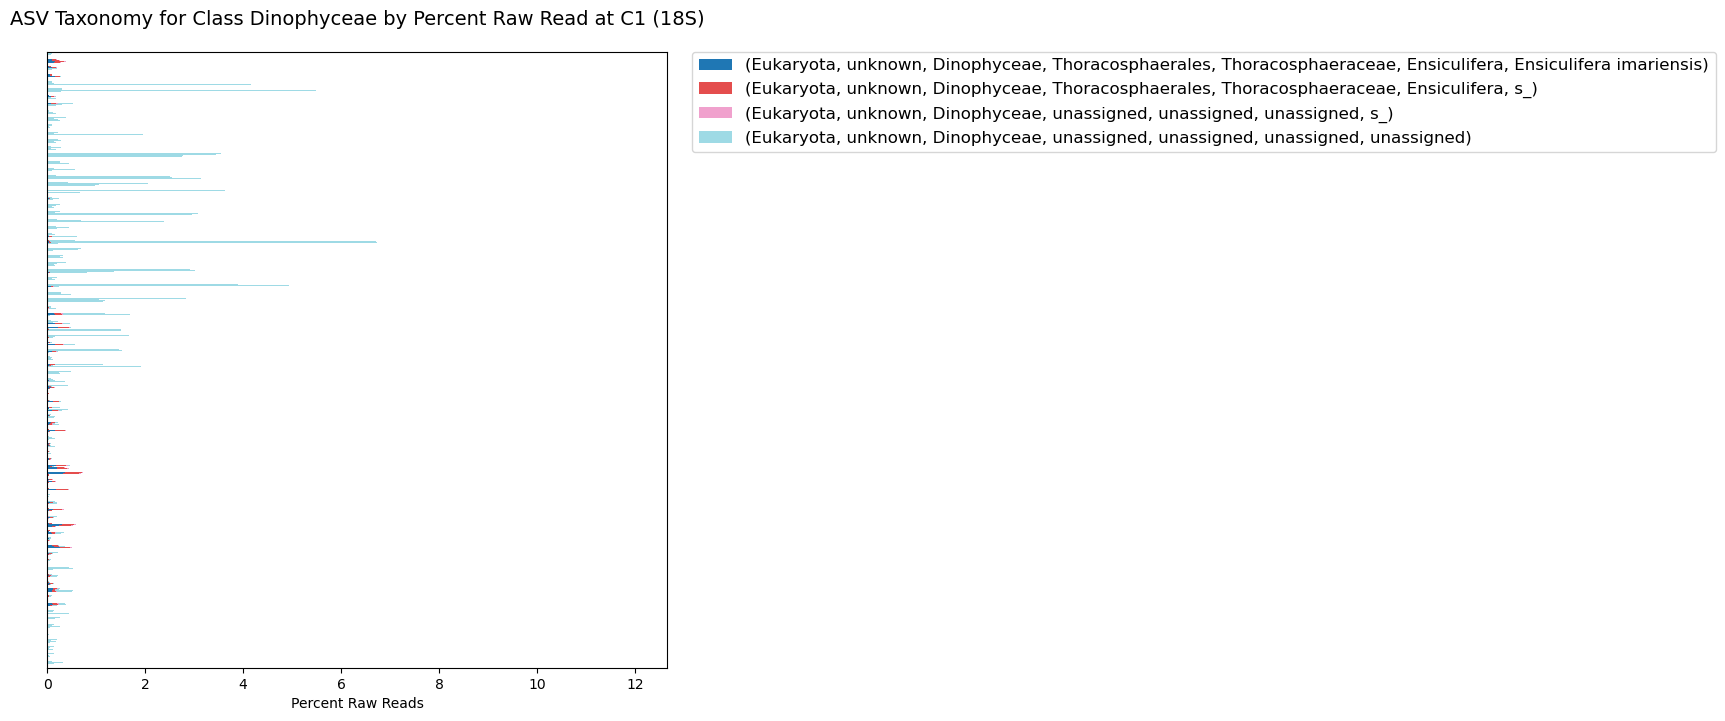

In [7]:
cmap=pr.mpl_colormap
df_top18.plot(kind='barh',stacked=True, cmap=cmap, figsize=[8,8])
plt.legend(bbox_to_anchor=(1.04, 1), loc=2, borderaxespad=0.,ncol=1, fontsize='12')
plt.gca().set_yticks([])
plt.title('ASV Taxonomy for Class Dinophyceae by Percent Raw Read at C1 (18S)', y=1.03, fontsize='14')
plt.xlabel('Percent Raw Reads')
#plt.savefig("Seasonal_images/Identified_biplot_taxa_18S_P_Bacillariophyta.png", dpi=300, bbox_inches='tight')

plt.show()

#### PC1, PC2, PC3

In [8]:
df_pc1_dia = coords_df_dia.join(df_meta18[['date', 'nitrate']], how='inner')
df_pc1_din = coords_df_din.join(df_meta18[['date', 'nitrate']], how='inner')
df_pc1_din['Date'] = pd.to_datetime(df_pc1_din['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_pc1_din = df_pc1_din.sort_values('Date', ascending=True)
df_pc1_din['month'] = df_pc1_din['Date'].dt.month
df_pc1_din['Year'] = df_pc1_din['Date'].dt.year

df_pc1_dia['Date'] = pd.to_datetime(df_pc1_dia['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_pc1_dia = df_pc1_dia.sort_values('Date', ascending=True)
df_pc1_dia['month'] = df_pc1_dia['Date'].dt.month
df_pc1_dia['Year'] = df_pc1_dia['Date'].dt.year

In [9]:
x = df_pc1_dia['Date'] 
y = df_pc1_dia['PC2']
y2 = df_pc1_din['PC2']

y = y.rolling(window=5, center=True).mean()
y2 = y2.rolling(window=5, center=True).mean()

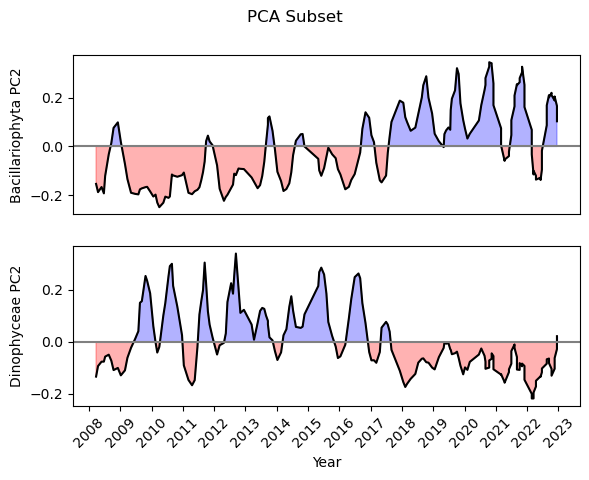

In [10]:
plt.style.use('default')
plt.figure(figsize=(6, 5))
plt.suptitle('PCA Subset', fontsize=12, y=0.95)

plt.subplot(2, 1, 1)
plt.plot(x, y, '-', color='black')
plt.fill_between(x, 0, y, where=(y > 0), interpolate=True, color='blue', alpha=0.3)
plt.fill_between(x, y, 0, where=(y < 0), interpolate=True, color='red', alpha=0.3)
plt.axhline(0, color='grey', linestyle='-')
plt.ylabel('Bacillariophyta PC2')
plt.gca().set_xticks([])

ax3 = plt.subplot(2, 1, 2)
plt.plot(x, y2, '-', color='black')
plt.fill_between(x, 0, y2, where=(y2 > 0), interpolate=True, color='blue', alpha=0.3)
plt.fill_between(x, y2, 0, where=(y2 < 0), interpolate=True, color='red', alpha=0.3)
plt.axhline(0, color='grey', linestyle='-')
plt.ylabel('Dinophyceae PC2')
plt.gca().set_xticks([])

years = sorted(df_pc1_dia['Date'].dt.year.unique())
tick_positions = [pd.Timestamp(f"{year}-01-01") for year in years]
ax3.set_xticks(tick_positions)
ax3.set_xticklabels([str(year) for year in years], rotation=45)

plt.xlabel('Year')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.2)
plt.style.use('default')
#plt.savefig("Seasonal_images/PCA_18S_Subset_w5.png", dpi=300, bbox_inches='tight')
plt.show()

### Color PCA seasonally

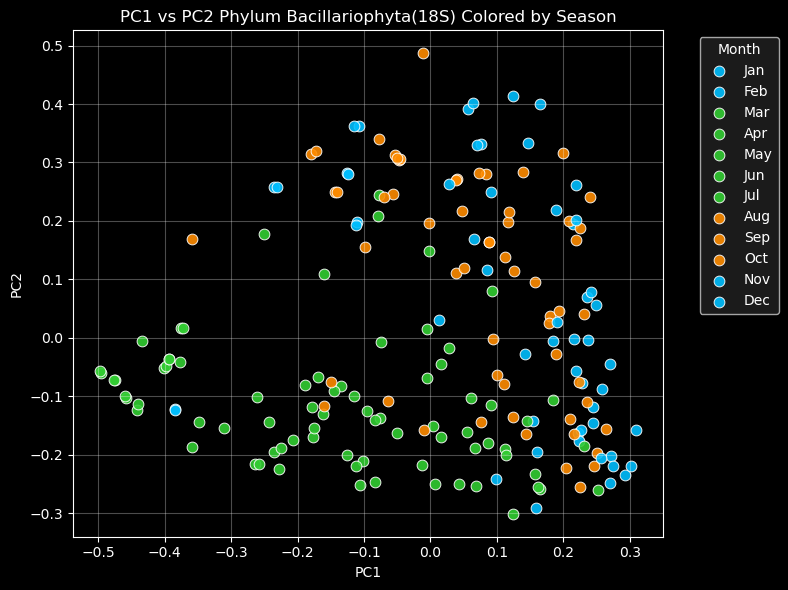

In [40]:
season_colors = {
    'Winter': '#00BFFF',  # DeepSkyBlue
    'Upwelling': '#32CD32',  # LimeGreen
    'Oceanic': '#FF8C00',  # DarkOrange
}
month_to_season = {
    1: 'Winter', 2: 'Winter', 12: 'Winter',
    3: 'Upwelling', 4: 'Upwelling', 5: 'Upwelling',
    6: 'Upwelling', 7: 'Upwelling', 8: 'Oceanic',
    9: 'Oceanic', 10: 'Oceanic', 11: 'Winter'
}

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.style.use('dark_background')
plt.figure(figsize=(8, 6))

for month in range(1, 13):
    mask = df_pc1_dia['month'] == month
    season = month_to_season[month]
    plt.scatter(
        df_pc1_dia.loc[mask, 'PC1'],
        df_pc1_dia.loc[mask, 'PC2'],
        color=season_colors[season],
        alpha=0.9,
        edgecolor='white',
        linewidth=0.7,
        label=month_names[month - 1],
        s=60
    )

plt.title('PC1 vs PC2 Phylum Bacillariophyta(18S) Colored by Season')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True, alpha=0.3)
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left', facecolor='#222222')
plt.tight_layout()
#plt.savefig("Seasonal_images/PC2vsPC3_C_BacillariophytaDinophyceae.png", dpi=300, bbox_inches='tight')
plt.show()


### See PC1 and PC2 for both groups

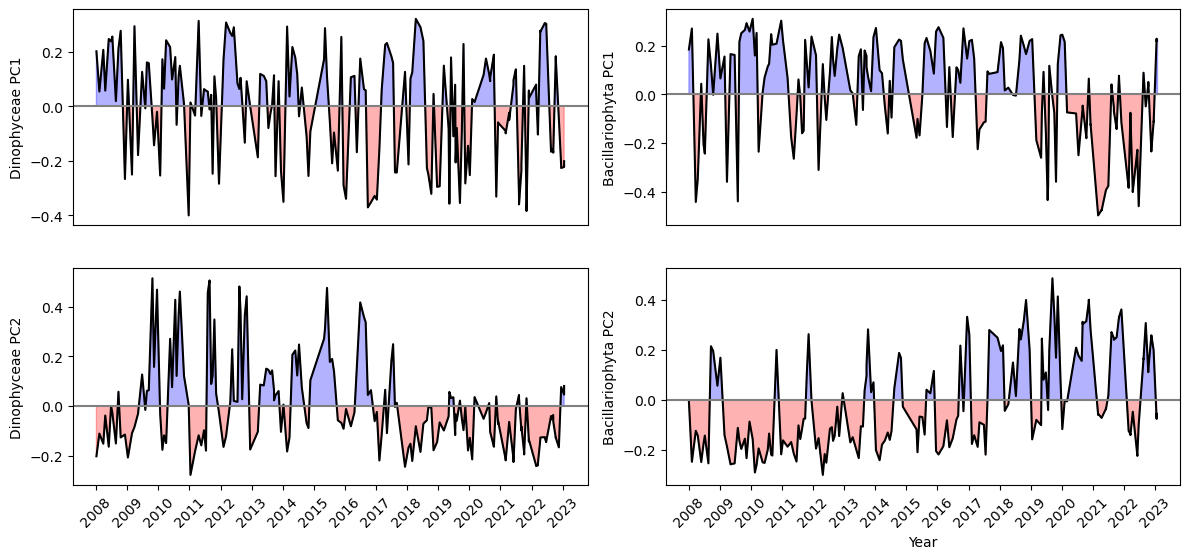

In [11]:
x = df_pc1_din['Date'] 
y = df_pc1_din['PC1']
y2 = df_pc1_din['PC2']
y3 = df_pc1_dia['PC1']
y4 = df_pc1_dia['PC2']

y = y.rolling(window=1, center=True).mean()
y2 = y2.rolling(window=1, center=True).mean()
y3 = y3.rolling(window=1, center=True).mean()
y4 = y4.rolling(window=1, center=True).mean()

plt.style.use('default')
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(x, y, '-', color='black')
plt.fill_between(x, 0, y, where=(y > 0), interpolate=True, color='blue', alpha=0.3)
plt.fill_between(x, y, 0, where=(y < 0), interpolate=True, color='red', alpha=0.3)
plt.axhline(0, color='grey', linestyle='-')
plt.ylabel('Dinophyceae PC1')
plt.gca().set_xticks([])

ax2 = plt.subplot(2, 2, 3)
plt.plot(x, y2, '-', color='black')
plt.fill_between(x, 0, y2, where=(y2 > 0), interpolate=True, color='blue', alpha=0.3)
plt.fill_between(x, y2, 0, where=(y2 < 0), interpolate=True, color='red', alpha=0.3)
plt.axhline(0, color='grey', linestyle='-')
plt.ylabel('Dinophyceae PC2')
plt.gca().set_xticks([])

ax3 = plt.subplot(2, 2, 2)
plt.plot(x, y3, '-', color="black")
plt.fill_between(x, 0, y3, where=(y3 > 0), interpolate=True, color='blue', alpha=0.3)
plt.fill_between(x, y3, 0, where=(y3 < 0), interpolate=True, color='red', alpha=0.3)
plt.axhline(0, color='grey', linestyle='-')
plt.ylabel('Bacillariophyta PC1')
plt.gca().set_xticks([])


ax4 = plt.subplot(2, 2, 4)
plt.plot(x, y4, '-', color="black")
plt.fill_between(x, 0, y4, where=(y4 > 0), interpolate=True, color='blue', alpha=0.3)
plt.fill_between(x, y4, 0, where=(y4 < 0), interpolate=True, color='red', alpha=0.3)
plt.axhline(0, color='grey', linestyle='-')
plt.ylabel('Bacillariophyta PC2')

years = sorted(df_pc1_dia['Date'].dt.year.unique())
tick_positions = [pd.Timestamp(f"{year}-01-01") for year in years]
ax4.set_xticks(tick_positions)
ax4.set_xticklabels([str(year) for year in years], rotation=45)

years = sorted(df_pc1_dia['Date'].dt.year.unique())
tick_positions = [pd.Timestamp(f"{year}-01-01") for year in years]
ax2.set_xticks(tick_positions)
ax2.set_xticklabels([str(year) for year in years], rotation=45)

plt.xlabel('Year')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.2)
plt.style.use('default')
#plt.savefig("Seasonal_images/Yearly_PCA_18S_C_Dinophyceae.png", dpi=300, bbox_inches='tight')
plt.show()